## PS摳圖

利用OpenCV 練習 像PS的摳圖

In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt

建立顯示圖片的函數 

In [2]:
def show(image): 
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    plt.imshow(img,origin='upper') #upper 0,0在左上角  lower就是0,0在左下角，會連圖片一起翻轉
    plt.show()

opencv的圖片默認使用BGR圖像格式，
而通常使用的圖片是RGB（紅，綠，藍），
所以，需要再轉換一下格式，
否則查看時顏色會失真。

In [3]:
def imageInfo(imgPath):
    img = cv2.imread(imgPath)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)       #轉換顏色模型 
    print("Type of OpenCV image: " , str(type(img))) #圖片的型態是ndarray
    print()
    print("Shape of OpenCV image:" , img.shape)      #查看圖片維度 （高，寬，channel)
    show(img)
    return img

導入前景圖 

Type of OpenCV image:  <class 'numpy.ndarray'>

Shape of OpenCV image: (1000, 673, 3)


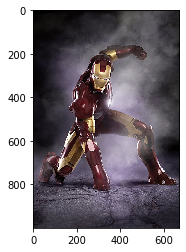

In [4]:
frontImg = imageInfo('/Users/jennielin/Desktop/photo.jpeg')

導入背景圖 

Type of OpenCV image:  <class 'numpy.ndarray'>

Shape of OpenCV image: (1080, 1080, 3)


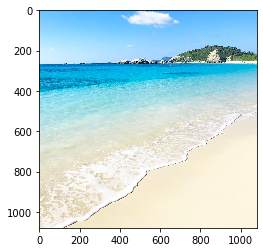

In [5]:
back_img = imageInfo('/Users/jennielin/Desktop/14705083_680002722173832_5261858322314690560_n.jpg') 

圖片在計算機中是用數字矩陣形式保存的，紅、綠、藍三個顏色通道每種色各分為256階，分別由0-255這256個數表示。比如900*360的圖片，可以理解為900（-> 寬 ）行360列 （-> 高）  的像素矩陣，而每個像素又是由R，G，B三個數字確認其顏色的。於是，我們先把圖片的行，列數記錄下來，稍後可以用諸如遍歷的方法讀取每個像素，再對其進行矩陣計算。

拆分圖片信息 

In [6]:
rows,cols,channels = frontImg.shape 

摳圖的方法雷同PS，要先建立個蒙版。在開始之前，我們先需要把圖片轉換成HSV格式，這是一種比較直觀的顏色模型，可以更好的數字化處理顏色。


把圖片轉換成HSV格式，用於摳圖 

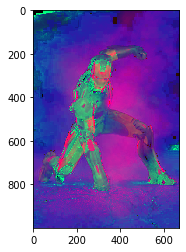

In [7]:
img_hsv = cv2.cvtColor(frontImg, cv2.COLOR_RGB2HSV)
show(img_hsv)

把綠色的部分提取出來。設定一個閾值，在最小閾值以下和最大閾值以上，圖像變為0，而在閾值之間的變為255。

摳圖 

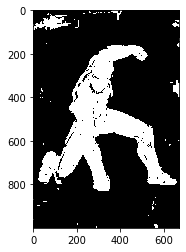

In [9]:
lower_blue=np.array([15,15,15])                     #最小閾值 
upper_blue=np.array([150,255,255])                  #最大閾值 
mask = cv2.inRange(img_hsv, lower_blue, upper_blue) #創建遮罩
show(mask) 

人物中間有那麼多小點點，需要把它們去掉。這裡使用形態學圖像處理的基本方法，先腐蝕後膨脹。其原理是在原圖的小區域內取局部最小值和最大值，背後的邏輯為深度學習中的卷積神經網絡。

還可以使用開運算（先腐蝕後膨脹的整合運算）直接完成這一過程

In [10]:
#res = cv2.bitwise_and(frontImg, frontImg, mask=mask)    # 對原圖像和掩模進行位運算
#show(res)

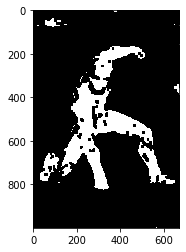

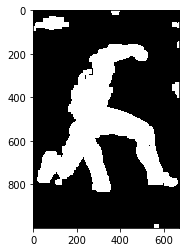

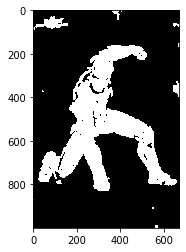

In [11]:
#圖像腐蝕 
erode=cv2.erode(mask,None,iterations=5)  
show(erode) 

#圖像膨脹
dilate=cv2.dilate(erode,None,iterations=10)  
show(dilate) 

#開運算 
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8,8)))  
show(opening) 

從上面三個比較的結果，發現開運算的結果是最好的，因此最後呈現用開運算

圖像合併環節。先設定人物在背景圖中的起始位置。再遍歷遮罩中的每個像素，如果是255（代表白色），則把人物圖像上的顏色賦值到背景圖像上。

因為摳圖的方法是採用把RGB的顏色轉成HSV去取想要的範圍，因此若選取的範圍與其他空間的顏色剛好差不多，就會把其他地方的也一起取到，所以最後呈現會有不是要選取的範圍

In [12]:
center = [70,240]    #設置前景圖開始位置 

for i in range(rows): 
    for j in range(cols): 
        if opening[i,j]==255:             #代表白色 
            back_img[center[0]+i,center[1]+j] = frontImg[i,j] #賦值顏色

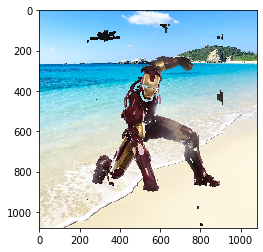

In [13]:
show(back_img) 

In [18]:
#如何找到要跟蹤物件的HSV值
#可以使用這個函式 cv2.cvtColor(),但是需要輸入的引數是BGR值,而不是一副圖片。例如,要找到綠色的HSV值

In [14]:
import cv2
import numpy as np
green = np.uint8([[[0,255,0 ]]])   #不能輸入[0,255,0] 因為是三個channel
hsv_green = cv2.cvtColor(green,cv2.COLOR_BGR2HSV)
print(hsv_green)

[[[ 60 255 255]]]


按比例混合起來，有不同的權重 ，給人一種混合的或者透明的感覺

In [15]:
#dst=cv2.addWeighted(back_img,0.7,img2,0.3,0)
#show(dst)

https://www.twblogs.net/a/5bb03a202b7177781a0fdf6d

### 使用opencv的add，圖片大小必須一樣

In [16]:
#縮放圖片 
#print(img2.shape) 
#列印圖片規格 
#img2=cv2.resize(img2,None,fx=0.3,fy=0.3) 
#圖片縮小10% 
#print(img2.shape) 
#列印圖片規格

In [17]:
#裁剪圖片 
#img2 = img[0:700, 0:700]  #前面是高 ，後面是長（寬），保留原始圖片
#裁剪圖片大小 
#show(img2) 
#顯示圖片
#print(img2.shape) 
#列印圖片規格 